In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import requests
import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
md_zip_ranges = [
    (20331,20331),
    (20335,20797),
    (20812,21930)
]

md_cities = pd.DataFrame(
    {'City':      ['Baltimore','Annapolis','Hagerstown','Frederick', 'Ft. Meade',
                   'Salisbury', 'Ocean City', 'Bethesda', 'Cumberland', 'College Park'],
     'Latitude':  [39.289452,    38.978132,  39.642500,  39.4141457, 39.1038739, 
                   38.3654624, 38.332159, 38.984372, 39.648437, 38.9897],
     'Longitude': [-76.613124,  -76.488142, -77.718646, -77.4092184,-76.742847, 
                   -75.5983227, -75.087294, -77.094755, -78.762657, -76.9378]
    }
)

cities_df = gpd.GeoDataFrame(
    md_cities, geometry=gpd.points_from_xy(md_cities.Longitude, md_cities.Latitude))

md_zips = ['%05d' % zipc for zip_range in md_zip_ranges
                     for zipc in range(zip_range[0],zip_range[1]+1)]

cases = pd.DataFrame(
    [np.NaN for _ in range(len(md_zips))],
    index=md_zips,
    columns=['cases']
)


# MD County COVID-19 Cases By Zip Code

In [3]:
zips_json = requests.get('https://services.arcgis.com/njFNhDsUCentVYJW/arcgis/rest/services/ZIPCodes_MD_1/FeatureServer/0/query?f=json&where=ProtectedCount%3E%3D8&returnGeometry=false&spatialRel=esriSpatialRelIntersects&outFields=*&orderByFields=ZIPCODE1%20asc&resultOffset=0&resultRecordCount=300&cacheHint=true')
current_cases_d = dict((x['attributes']['ZIPCODE1'],x['attributes']['ProtectedCount'])
                        for x in zips_json.json()['features'])

current_cases = pd.DataFrame(
    current_cases_d.values(),
    index=current_cases_d.keys(),
    columns=['cases'])
current_cases

,cases
20601,43
20602,57
20603,79
20607,25
20613,43
...,...
21801,23
21804,31
21811,11
21911,25


In [4]:
cases.update(current_cases)
cases[cases['cases'].notnull()]

,cases
20601,43.0
20602,57.0
20603,79.0
20607,25.0
20613,43.0
...,...
21801,23.0
21804,31.0
21811,11.0
21911,25.0


Loading 2010 census data by zip code.  Data is broken down by age range and gender.  Summary rows have no gender.

population,minimum_age,maximum_age,gender,zipcode,geo_id

In [5]:
pop = pd.read_csv('population_by_zip_2010.csv',dtype={'zipcode': str})
pop['ZIPCODE'] = pop['zipcode']
pop.set_index('ZIPCODE')

print(type(pop['ZIPCODE'].values[0]))
pop = pop[(pop['gender'] != 'male') & (pop['gender'] != 'female')]

<class 'str'>


Merge case data for Anne Arundel county with population

In [6]:
pop_cases = cases.merge(pop,left_on=cases.index,right_on='ZIPCODE')
pop_cases.loc[pop_cases.ZIPCODE == '20740']

,cases,population,minimum_age,maximum_age,gender,zipcode,geo_id,ZIPCODE
96,41.0,28780,NaN,NaN,NaN,20740,8600000US20740,20740


Read zip codes geo file and merge with population data

In [7]:
zips = gpd.read_file('cb_2018_us_zcta510_500k.shp')
zips['ZIPCODE'] = zips['ZCTA5CE10']
zips.set_index('ZIPCODE')
zips = zips.merge(pop_cases,on='ZIPCODE',how='inner')
zips

,ZCTA5CE10,AFFGEOID10,GEOID10,ALAND10,AWATER10,geometry,ZIPCODE,cases,population,minimum_age,maximum_age,gender,zipcode,geo_id
0,21529,8600000US21529,21529,9382561,85948,"POLYGON ((-78.78953 39.72296, -78.77455 39.722...",21529,NaN,631,NaN,NaN,NaN,21529,8600000US21529
1,20899,8600000US20899,20899,204571,0,"POLYGON ((-77.21909 39.14701, -77.21505 39.145...",20899,NaN,142,NaN,NaN,NaN,20899,8600000US20899
2,21717,8600000US21717,21717,944626,10584,"POLYGON ((-77.44416 39.33554, -77.43851 39.341...",21717,NaN,54,NaN,NaN,NaN,21717,8600000US21717
3,21802,8600000US21802,21802,136026,0,"POLYGON ((-75.58453 38.34543, -75.58163 38.346...",21802,NaN,89,NaN,NaN,NaN,21802,8600000US21802
4,20520,8600000US20520,20520,83729,0,"POLYGON ((-77.05012 38.89602, -77.04802 38.896...",20520,NaN,0,NaN,NaN,NaN,20520,8600000US20520
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
479,21671,8600000US21671,21671,5472621,8925145,"POLYGON ((-76.34647 38.69205, -76.34380 38.695...",21671,NaN,756,NaN,NaN,NaN,21671,8600000US21671
480,21104,8600000US21104,21104,43984996,1909783,"POLYGON ((-76.95129 39.31348, -76.95050 39.312...",21104,9.0,4601,NaN,NaN,NaN,21104,8600000US21104
481,20687,8600000US20687,20687,16037034,20293062,"POLYGON ((-76.38286 38.09058, -76.38138 38.091...",20687,NaN,313,NaN,NaN,NaN,20687,8600000US20687
482,21131,8600000US21131,21131,57562383,3576073,"POLYGON ((-76.63103 39.53060, -76.62870 39.531...",21131,10.0,7253,NaN,NaN,NaN,21131,8600000US21131


# Cases per 1,000

In [8]:
zips['density'] = zips['cases'] / (zips['population'] / 1_000)
zips.set_index('ZIPCODE')
print(zips[zips.density.notnull()][['ZIPCODE','density','cases','population']].sort_values('density').tail())

    ZIPCODE   density  cases  population
244   20769  3.785584   25.0        6604
469   20722  3.852215   22.0        5711
149   20706  4.186912  162.0       38692
245   21133  4.633642  139.0       29998
302   20623  5.102041   14.0        2744


In [9]:
print(zips[zips.zipcode == '20740']['geometry'])

220    POLYGON ((-76.96535 39.00242, -76.96058 39.003...
Name: geometry, dtype: geometry


In [10]:
top5_zips = pd.DataFrame(
    {'City':      [],
     'Latitude':  [],
     'Longitude': []
    }
)

zip_names = dict((x['attributes']['ZIPCODE1'], x['attributes']['ZIPName'])
                        for x in zips_json.json()['features'])

for index, row in (zips[zips.density.notnull()][['ZIPCODE','density','cases','population']].sort_values('density').tail()).iterrows():
    city = zip_names[row['ZIPCODE']]
    point = zips[zips.zipcode == row['ZIPCODE']]['geometry'].centroid
    
    # this is an ugly hack to go back to lat and long
    point_str = str(point).split()
    long = float(point_str[2][1:])
    lat = float(point_str[3][:-1])
    #print ({'City':city, 'Latitude':lat, 'Longitude':long})
    top5_zips = top5_zips.append({'City':city, 'Latitude':lat, 'Longitude':long}, ignore_index=True) 
    
top5_zips_df = gpd.GeoDataFrame(
    top5_zips, geometry=gpd.points_from_xy(top5_zips.Longitude, top5_zips.Latitude))

print (top5_zips_df)


           City  Latitude  Longitude                    geometry
0    Glenn Dale  38.99349  -76.81993  POINT (-76.81993 38.99349)
1     Brentwood  38.93512  -76.94943  POINT (-76.94943 38.93512)
2        Lanham  38.96564  -76.85094  POINT (-76.85094 38.96564)
3  Randallstown  39.37477  -76.81246  POINT (-76.81246 39.37477)
4    Cheltenham  38.74247  -76.83723  POINT (-76.83723 38.74247)


AttributeError: 'PathCollection' object has no property 'weight'

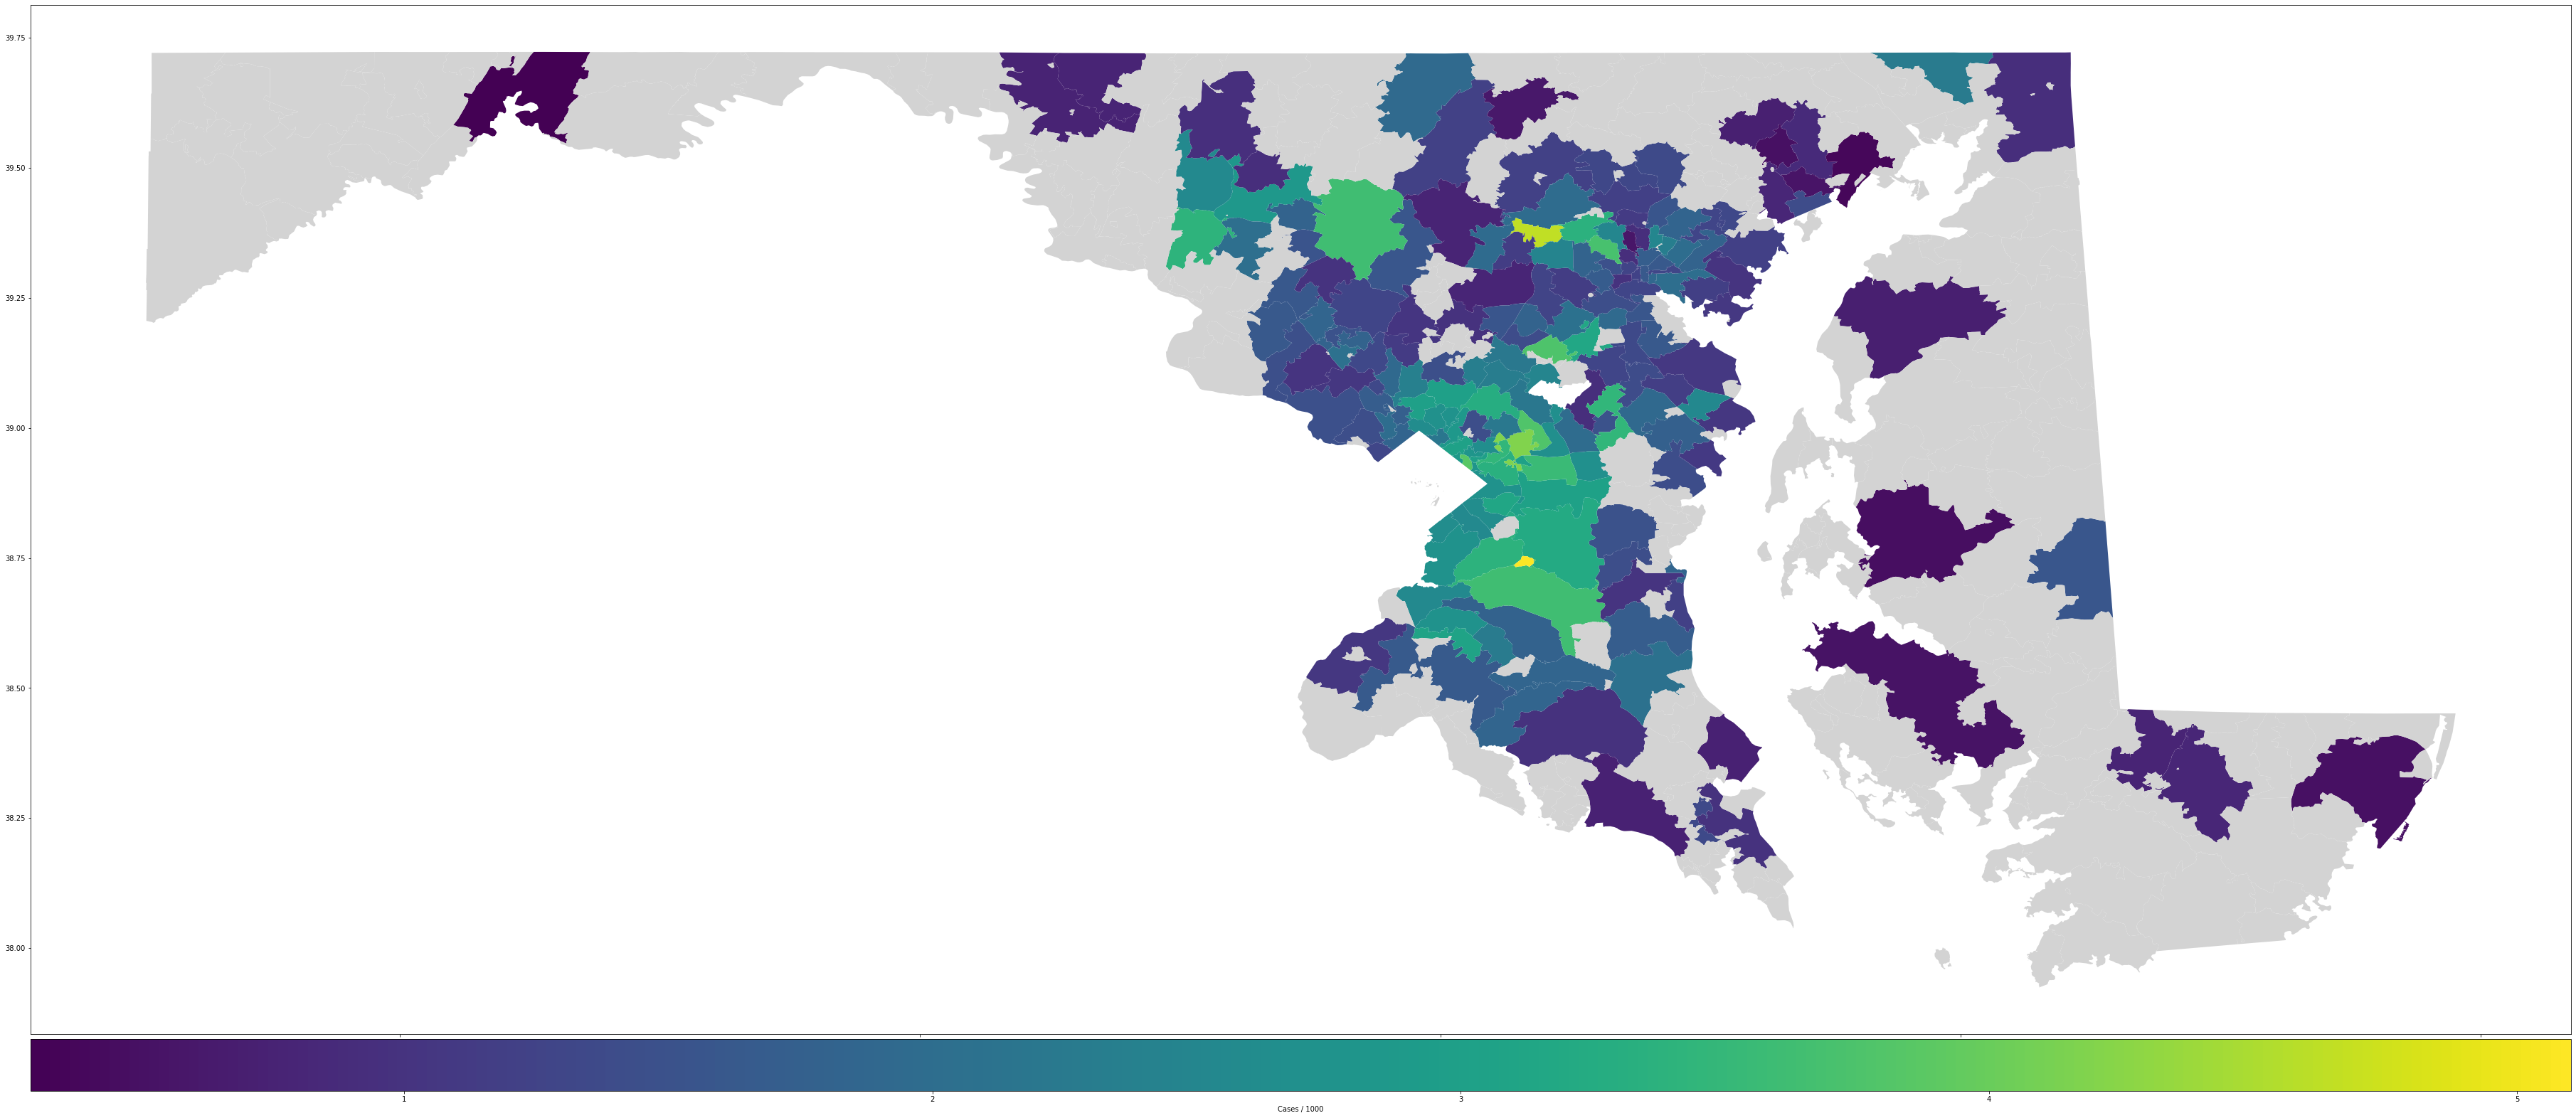

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(64,32))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)
zplot = zips.plot(column='density',
                  legend=True,
                  figsize=(32,24),
                  ax=ax, cax=cax,
                  legend_kwds={
                    'label': "Cases / 1000",
                    'orientation': "horizontal"  
                  },
                  missing_kwds={
                      "color": "lightgrey",
                      "label": "Missing values"
                  })


cities_plot = cities_df.plot(ax=zplot,marker='o',color='white',markersize=15)
_ = cities_df.apply(lambda x: cities_plot.annotate(s=x.City, 
                                                   xy=x.geometry.centroid.coords[0], 
                                                   ha='center', color='white',weight='bold'),
                    axis=1)

cities_plot = top5_zips_df.plot(ax=zplot,marker='o',color='red',markersize=10)
_ = top5_zips_df.apply(lambda x: cities_plot.annotate(s=x.City, 
                                                   xy=x.geometry.centroid.coords[0], 
                                                   ha='center', color='red',),
                    axis=1)
today = datetime.date.today().strftime('%Y-%m-%d')

plt.savefig('%s-MD-density.png' % today)